In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
from tensorflow.python.keras.applications import InceptionV3
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [3]:
# model = ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3), pooling=max, classes=7)

# model = InceptionV3(weights = 'imagenet', include_top=False)
model = InceptionV3(include_top=True, weights=None, input_shape=(224, 224, 3), pooling=max, classes=7)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.summary()

In [5]:
import pandas as pd

# data = pd.read_csv('./dataset.csv',index_col=0)
data = pd.read_csv('/home/ncp/workspace/data/dataset_.csv',index_col=0)

In [6]:
data.head(1)

,identifier,sex,age_group,age,height,weight,report,pneumonia_type,orginal_dcm_file,orginal_png_file,crop_file,body_part_file,diagnosis
0,H05_00019_02,M,A1,0개월,NaN,0.9,NaN,NaN,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/crop/d4/H05_00019_02.png,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,4


In [7]:
crop_list = list(data['crop_file'])

In [8]:
import cv2
import matplotlib.pyplot as plt

# plt.imshow(cv2.imread(crop_list[0]))
# print(cv2.imread(crop_list[0]).shape)

In [9]:
import numpy as np
import cv2

def cvt_crop(og_img_path, size):
    
    og_img = cv2.imread(og_img_path)
    
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(8,8))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)

    return cvt_img
#     print(remove.shape)
#     plt.imshow(remove)

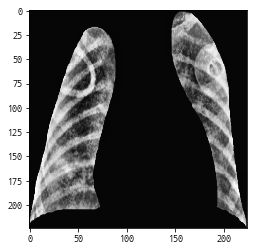

In [10]:
plt.imshow(cvt_crop(crop_list[0], (224,224)))

In [11]:
def normal_dia(x):
    if x == 9:
        return 0
    else:
        return x
    
    
data['diagnosis'] = data['diagnosis'].apply(normal_dia)

In [12]:
len(data)

4000

In [11]:
dcm_list = list(data['orginal_dcm_file'])
mask_path_list = list(data['body_part_file'])
img_path_list = []

for i in dcm_list:
    png_img = i.replace('.dcm','.png')
    img_path_list.append(png_img)

In [12]:
import numpy as np

def rv_3ch(og_img_path, mask_path, size):
    
    #module import
    import cv2
    
    # im_read
    og_img = cv2.imread(og_img_path)
    mask = cv2.imread(mask_path)
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(8,8))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)

    ## mask
    cvt_mask = cv2.resize(mask, size)
    cvt_mask = cv2.cvtColor(cvt_mask, cv2.COLOR_BGR2GRAY)

    ## remove
    remove = cv2.bitwise_and(cvt_img, cvt_img, mask = cvt_mask)
    
    return remove
#     print(remove.shape)
#     plt.imshow(remove)

In [13]:
X = np.ndarray((4000,224,224,3))

for i in range(len(X)):
#     X[i][:][:][:] = rv_3ch(img_path_list[i], mask_path_list[i], (224,224))
      X[i][:][:][:] = cvt_crop(crop_list[i], (224,224)).astype(np.uint8)
    
y = np.array(data['diagnosis'])

In [14]:
from sklearn.model_selection import train_test_split

Xtr, Xva, Ytr, Yva = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
Xva, Xtst, Yva, Ytst = train_test_split(Xva,Yva, test_size=0.5, random_state=42, stratify=Yva)

In [15]:
from tensorflow.python.keras.utils import to_categorical

Ytr_c = to_categorical(Ytr)
Yva_c = to_categorical(Yva)
Ytst_c = to_categorical(Ytst)

In [16]:
print(Ytr.shape)
print(Yva.shape)
print(Ytst.shape)

(3200,)
(400,)
(400,)


In [41]:
Ytr_c

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['acc'])

In [18]:
X[1].shape

(224, 224, 3)

In [19]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


#data augmentation 

# Create two instances (images and targets) with the same arguments
data_gen_args = dict(zoom_range=0.2, horizontal_flip=True, vertical_flip = True, rotation_range = 10)
image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)
ZeroDivisionError
seed = 1

train_generator = image_datagen.flow(x=Xtr, y=Ytr_c,
                                    batch_size=32,
                                    shuffle=True,
                                    )

validation_generator = image_datagen.flow(x=Xva,y=Yva_c,
                                         batch_size=32,
                                         shuffle=True)
#image should have rank 4
# image_datagen.fit(Xtr, augment=True, seed=seed)
# mask_datagen.fit(Ytr, augment=True, seed=seed)

# image_generator = image_datagen.flow(Xtr,seed=seed)

# mask_generator = mask_datagen.flow(Ytr,seed=seed)

# combine generators into one which yields image and masks
# train_generator = zip(image_generator, mask_generator)


In [ ]:
history = model.fit_generator(train_generator, epochs=20, validation_data=validation_generator)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
100/100 [==============================] - 76s 756ms/step - loss: 1.8400 - acc: 0.3066 - val_loss: 1.8747 - val_acc: 0.2650
Epoch 2/20
100/100 [==============================] - 36s 361ms/step - loss: 1.6335 - acc: 0.3278 - val_loss: 4.1142 - val_acc: 0.2900
Epoch 3/20
100/100 [==============================] - 37s 368ms/step - loss: 1.5569 - acc: 0.3591 - val_loss: 3.9612 - val_acc: 0.2325
Epoch 4/20
100/100 [==============================] - 36s 359ms/step - loss: 1.5283 - acc: 0.3597 - val_loss: 5.3507 - val_acc: 0.2300
Epoch 5/20
100/100 [==============================] - 36s 365ms/step - loss: 1.5145 - acc: 0.3794 - val_loss: 1.5058 - val_acc: 0.3825
Epoch 6/20
100/100 [==============================] - 37s 371ms/step - loss: 1.4610 - acc: 0.3931 - val_loss: 1.7910 - val_acc: 0.2950
Epoch 7/20
100/100 [==============================] - 37s 372ms/step - loss: 1.4222 - acc: 0.4253 - val_loss: 2.1250 - val_acc: 0.3225
Epoch 8

In [26]:
# history = model.fit(image_generator,Ytr_c, validation_data=[Xva, Yva_c], batch_size=8, epochs=20,verbose=1)

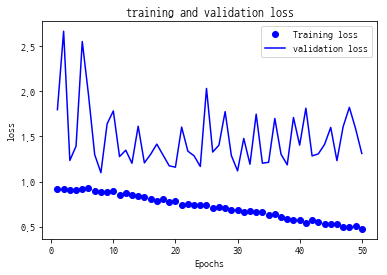

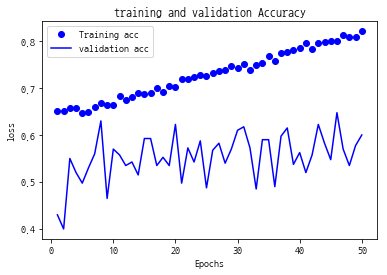

In [23]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.clf()

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.clf()
acc= history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()